# Set up deps

In [ ]:
# Install ipyml
!conda install -c conda-forge -y ipympl

In [2]:
import os

import cupy as cp
import pandas as pd
import cudf
import re
import pprint as pp
import json

from pandas import json_normalize
from cudf.core.column import as_column

# Data import

In [ ]:
df = cudf.read_json("/datasets/linkedin/linkedin_public_sample_usa.txt", engine='cudf_experimental', lines=True, keep_quotes=True)
df.head(2)

# Analysis

Currently in a management position.

In [ ]:
# Metadata inference method
def infer_metadata(title):
  manager_pattern = re.compile(r'(manager)', flags=re.IGNORECASE)
  senior_manager_pattern = re.compile(r'(director)', flags=re.IGNORECASE)
  executive_pattern = re.compile(r'(president|vice president|[\s]?VP[\s]?|[\s]?SVP[\s]?|[\s]?EVP[\s]?|[\s]?AVP[\s]?)', flags=re.IGNORECASE)
  csuite_pattern = re.compile(r'([\s"]C[A-Z]O[\s]+)')
  global_filter = re.compile(r'(project manager|program manager|account manager|process manager|key account manager|marketing manager|product line manager|facility manager|product manager|project manager|office manager|analytics manager|recruiting manager|research_manager|compliance manager|engagement manager|proposal manager|media manager|procurement manager|assistant)', flags=re.IGNORECASE)
 
  metadata = {}

  if re.search(manager_pattern, title):
    if not re.search(global_filter, title):
        metadata = {"management": 1, "flavor": "management", "action": "matched"}
    else:
        metadata = {"management": 0, "flavor": "none", "action": "filtered"}
  elif re.search(senior_manager_pattern, title):
    if not re.search(global_filter, title):
        metadata = {"management": 1, "flavor": "senior_management", "action": "matched"}
    else:
        metadata = {"management": 0, "flavor": "none", "action": "filtered"}
  elif re.search(executive_pattern, title):
    if not re.search(global_filter, title):
        metadata = {"management": 1, "flavor": "executive", "action": "matched"}
    else:
        metadata = {"management": 0, "flavor": "none", "action": "filtered"}
  elif re.search(csuite_pattern, title):
    if not re.search(global_filter, title):
        metadata = {"management": 1, "flavor": "CXO", "action": "matched"}
    else:
        metadata = {"management": 0, "flavor": "none", "action": "filtered"}
  else:
    metadata = {"management": 0, "flavor": "none", "action": "not_matched"}
        
  return metadata

Iterate through experiences

In [5]:
job_title_durations = []
experiences_df = df[['experiences']]

# Function to calculate duration from start and end date dictionaries
def calculate_duration(start_date, end_date):
    if start_date and end_date:
        start_day, start_month, start_year = start_date['day'], start_date['month'], start_date['year']
        end_day, end_month, end_year = end_date['day'], end_date['month'], end_date['year']
        start_date = cudf.to_datetime(f"{int(start_year)}-{int(start_month)}-{int(start_day)}")
        end_date = cudf.to_datetime(f"{int(end_year)}-{int(end_month)}-{int(end_day)}")
        duration = (end_date - start_date).astype('timedelta64[D]').astype(int)
        return duration
    else:
        return None

# Populate the list with dictionary title<->duration pairs
for index, row in experiences_df.to_pandas().iterrows():
#for index, row in df.to_pandas().iterrows():
    experiences = row['experiences']
    for idx,position in enumerate(experiences):
        title=position.get('title')
        if title is not None:
              starts_at = position.get('starts_at', {})
              ends_at = position.get('ends_at', {})
              
              duration = calculate_duration(starts_at, ends_at)
              
              metadata = infer_metadata(title)
                
              if duration is not None:
                    job_title_durations.append({'experience': title, 'duration_days': duration, 'management': metadata["management"], 'flavor': metadata["flavor"], 'action': metadata["action"]})
                
# Dump into a Dataframe
df_job_title_durations = cudf.DataFrame(job_title_durations)
print("Collected %s records" % len(df_job_title_durations))
df_job_title_durations.to_csv("experiences_usa.csv")

Collected 42851 records


flavor
CXO                  896.5
executive            759.5
management           760.0
none                 424.0
senior_management    761.0
Name: duration_days, dtype: float64
       duration_days  management
count    5532.000000      5532.0
mean     1107.089841         1.0
std      1118.141693         0.0
min        27.000000         1.0
25%       396.000000         1.0
50%       760.000000         1.0
75%      1401.000000         1.0
max     17896.000000         1.0
       duration_days  management
count   37319.000000     37319.0
mean      669.253865         0.0
std       804.443706         0.0
min        27.000000         0.0
25%       180.000000         0.0
50%       424.000000         0.0
75%       850.000000         0.0
max     16740.000000         0.0


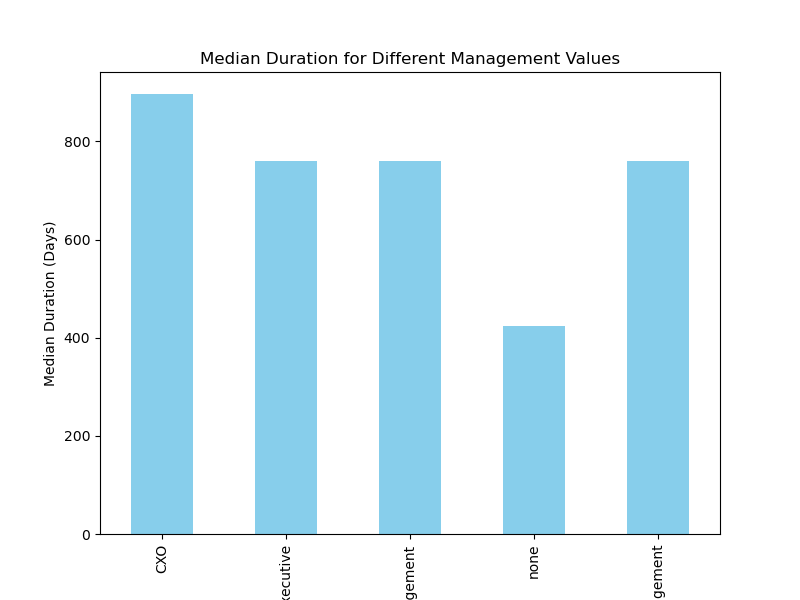

In [6]:
%matplotlib widget

import matplotlib.pyplot as plt

median_durations = df_job_title_durations.groupby('flavor')['duration_days'].median().to_pandas()
print(median_durations)

df_management_durations = df_job_title_durations[df_job_title_durations['management'] == 1]
df_non_management_durations = df_job_title_durations[df_job_title_durations['management'] == 0]

print(df_management_durations.describe())
print(df_non_management_durations.describe())

# Plot median duration
plt.figure(figsize=(8, 6))
median_durations.plot(kind='bar', color='skyblue')
plt.xlabel('Management')
plt.ylabel('Median Duration (Days)')
plt.title('Median Duration for Different Management Values')
plt.xticks(range(len(median_durations.index)), [str(x) for x in median_durations.index])
plt.show()